In [ ]:
# https://huggingface.co/distilbert-base-german-cased

# Multilingual Toxic Comment Classification with BERT

**Bidirectional Encoder Representations from Transformers (BERT)** is a deep learning model for NLP (Natural Language Processing) pre-training developed and released by Google in 2018. In practice, BERT provides pre-trained language models for English and 103 other languages that you can fine-tune to fit your needs.

BERT has been trained on Masked Language Modeling and Next Sentence Prediction. 

BERT uses the part of the Transformer network architecture introduced by the paper “Attention is all you need”. The advantage of this architecture is that it makes it possible to deal with relationships between distant words better than recurring networks (LSTM / GRU).

On the other hand, the network cannot process sequences of any length; instead, it has a finite entry dimension that cannot be too large (about 300–500 words in most networks). Otherwise, the network is unable to learn anything significant in a reasonable amount of training time.

For more information on the archtitecture and functionality of BERT click [here](https://ai.googleblog.com/2018/11/open-sourcing-bert-state-of-art-pre.html).


**Bert models** <br/>
Bert-base-multilingual-cased
+ Train on:12-layer, 768-hidden, 12-heads 110M parameters.
+ Train on 104 languages with Wikipedies 

Distilbert-base-multilingual-cased
+ Train on:6-layer, 768-hidden, 12-heads, 134M parameters
+ Train on 104 languages with Wikipedies

In [1]:
#workflow and statistics
import pandas as pd
import numpy as np
import matplotlib as matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

#natural language processing toolkit
import nltk
import string
from nltk.corpus import stopwords  # removes useless words
from nltk.stem.lancaster import LancasterStemmer  #converts the words to base form; aggressive
from nltk.stem import porter
from nltk.stem.util import suffix_replace, prefix_replace
from nltk.stem.api import StemmerI
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')

#accessing google cloud storage
#from google.cloud import storage
#from io import BytesIO
#client = storage.Client()
#bucket = "bilderkennung_nf_2020"

#building the model
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import train_test_split
import re
from tqdm import tqdm_notebook
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import regularizers, initializers, optimizers, callbacks
from tensorflow.keras.preprocessing import sequence, text
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tokenizers import BertWordPieceTokenizer, Tokenizer, models, pre_tokenizers, decoders, processors
from keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers.core import Dense, Activation, Dropout
#from tensorflow.keras.layers.embeddings import Embedding
#from tensorflow.keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

import transformers
from transformers import TFAutoModel, AutoTokenizer

import os
import glob

#evaluation metrics
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/student/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Using TensorFlow backend.


In [2]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [12]:
train1 = pd.read_csv("./jigsaw-toxic-comment-train.csv")
valid1 = pd.read_csv('./validation.csv')
test1 = pd.read_csv('./test.csv')

In [13]:
train = train1.sample(frac=0.09, random_state=1)

In [14]:
train.shape

(20119, 8)

In [15]:
valid = valid1.sample(frac=0.15, weights= 'toxic', random_state=1)

In [16]:
valid.shape

(1200, 4)

In [17]:
test = test1.sample(frac=0.25, random_state=1)

In [18]:
test.shape

(15953, 3)

In [19]:
x = train['toxic'].value_counts()

In [20]:
x.sort_values(0)

1     1953
0    18166
Name: toxic, dtype: int64

In [22]:
train['toxic'].shape

(20119,)

In [23]:
toxic = (1953/20119)*100
non_toxic = (18166/20119)*100

In [24]:
toxic

9.70724191063174

In [25]:
non_toxic

90.29275808936826

In [26]:
toxic = 9.7
non_toxic = 90.3

In [27]:
data_ = {'toxic':[11.4], 'non-toxic':[88.9]}
percentage = pd.DataFrame.from_dict(data_)
percentage.transpose()

,0
toxic,11.4
non-toxic,88.9


<Figure size 720x432 with 0 Axes>

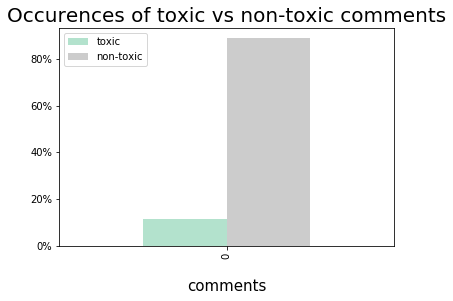

In [28]:
import matplotlib.ticker as mtick

plt.figure(1,figsize=(10,6))
ax = percentage.plot(kind='bar', colormap='Pastel2')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.title("Occurences of toxic vs non-toxic comments",fontsize=20)
#plt.ylabel('number of Occurrences', fontsize=15,labelpad=20)
plt.xlabel('comments', fontsize=15,labelpad=20)
plt.show()

## Text Cleaning

In [29]:
def remove_punctuation(text):
    '''a function for removing punctuation'''
    import string
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)
train['comment_text'] = train['comment_text'].apply(remove_punctuation)
valid['comment_text'] = valid['comment_text'].apply(remove_punctuation)
test['content'] = test['content'].apply(remove_punctuation)

In [30]:
sw=stopwords.words('english')
def removesw(text):
    '''a function for removing the stopword'''
    # removing the stop words and lowercasing the selected words
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    # joining the list of words with space separator
    return " ".join(text)
train['comment_text'] = train['comment_text'].apply(removesw)
valid['comment_text'] = valid['comment_text'].apply(removesw)
test['content'] = test['content'].apply(removesw)

In [31]:
stemmer = SnowballStemmer("english")

def stemming(text):    
    '''a function which stems each word in the given text'''
    text = [stemmer.stem(word) for word in text.split()]
    return " ".join(text) 
train['comment_text'] = train['comment_text'].apply(stemming)
valid['comment_text'] = valid['comment_text'].apply(stemming)
test['content'] = test['content'].apply(stemming)

## Model

In [32]:
#Function for Encoding the comment


def regular_encode(texts, tokenizer, maxlen=512):
    # encode the word to vector of integer

    encode_dictionary = tokenizer.batch_encode_plus(
        texts,
        return_attention_masks=False,
        return_token_type_ids=False,
        pad_to_max_length=True,
        max_length=maxlen,
        truncation=True)

    return np.array(encode_dictionary['input_ids'])

In [33]:
#Function for Neural Network Model

def build_model(transformer, max_len=512):

#Input: for define input layer
#shape is vector with 512-dimensional vectors
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
# to get the vector
    cls_token = sequence_output[:, 0, :]
# define output layer
    out = Dense(1, activation='sigmoid')(cls_token)
# initiate the model with inputs and outputs
    model = Model(inputs=input_word_ids, outputs=out)
# get the learning rate adam(1e-5) and the metrica
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])
    
    return model

In [34]:
EPOCHS = 3
BATCH_SIZE = 64 * strategy.num_replicas_in_sync # the batch size in each epoch (128)
MAX_LEN = 192

# distilbert pre-trained model is faster than the bert base model, but it give lower accuracy than the bert base
#MODEL ='distilbert-base-multilingual-cased'
#MODEL='bert-base-multilingual-cased'


MODEL='bert-base-multilingual-cased'

In [35]:
AUTO = tf.data.experimental.AUTOTUNE

In [36]:
#use the pre-trained model BERT as a tokenizer 
#bert tokenizer has vocabulary for emoji

tokenizer = AutoTokenizer.from_pretrained(MODEL)

In [37]:
%%time 
#call the function regular encode on for all the 3 dataset to convert each words after the tokenizer
#into a vector
#x_train,x_test, and x_validation will have the comment text column only,(in test called "content")

x_train = regular_encode(train.comment_text, tokenizer, maxlen=MAX_LEN)
x_valid = regular_encode(valid.comment_text, tokenizer, maxlen=MAX_LEN)
x_test = regular_encode(test.content, tokenizer, maxlen=MAX_LEN)

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': Fal

CPU times: user 57.9 s, sys: 7.7 s, total: 1min 5s
Wall time: 1min 9s


In [38]:
#y_train,y_valid will have te target column "toxic"
y_train = train.toxic.values
y_valid = valid.toxic.values

In [39]:
# Create and prepare a source dataset from your input data to fit the model in the next step.
# Apply dataset transformations to preprocess the data.
# Iterate over the dataset and process the elements.

train_dataset = (
    tf.data.Dataset # create dataset
    .from_tensor_slices((x_train, y_train)) # Once you have a dataset, you can apply transformations 
    .repeat()
    .shuffle(2048,seed=40) # Combines consecutive elements of this dataset into batches.
    .batch(BATCH_SIZE)
    .prefetch(AUTO)) #This allows later elements to be prepared while the current element 
                      #is being processed (pipline).


valid_dataset = (tf.data.Dataset.from_tensor_slices((x_valid, y_valid)).batch(BATCH_SIZE)
    .cache().prefetch(AUTO))

test_dataset = (tf.data.Dataset.from_tensor_slices(x_test).batch(BATCH_SIZE))

In [40]:
%%time
# in the TPU
with strategy.scope():
    #take the encoder results of bert from transformers and use it as an input in the NN model
    transformer_layer = TFAutoModel.from_pretrained(MODEL)
    model = build_model(transformer_layer, max_len=MAX_LEN)
model.summary()

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 192)]             0         
_________________________________________________________________
tf_bert_model (TFBertModel)  ((None, 192, 768), (None, 177853440 
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 768)]             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 769       
Total params: 177,854,209
Trainable params: 177,854,209
Non-trainable params: 0
_________________________________________________________________
CPU times: user 10.1 s, sys: 4.99 s, total: 15.1 s
Wall time: 7.71 s


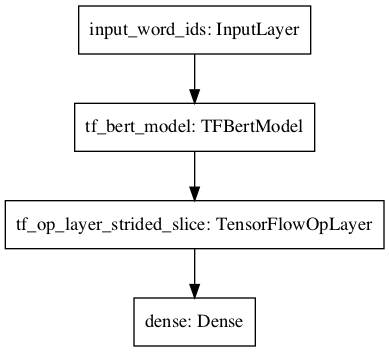

In [41]:
#visualize the model's architecture
tf.keras.utils.plot_model(model)

In [42]:
# train the model
# training the data and tune our model with the results of the metrics we get from the validation dataset
n_steps = x_train.shape[0] // BATCH_SIZE
train_history = model.fit(train_dataset, steps_per_epoch=n_steps, validation_data=valid_dataset,
                epochs=EPOCHS)

Epoch 1/3
314/314 [==============================] - 21583s 69s/step - loss: 0.2136 - auc: 0.8697 - val_loss: 1.6814 - val_auc: 0.0000e+00
Epoch 2/3
314/314 [==============================] - 20954s 67s/step - loss: 0.1319 - auc: 0.9597 - val_loss: 3.5421 - val_auc: 0.0000e+00
Epoch 3/3
314/314 [==============================] - 20574s 66s/step - loss: 0.1041 - auc: 0.9751 - val_loss: 3.8537 - val_auc: 0.0000e+00


In [43]:
# save model
model.save('BERT_model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: BERT_model/assets


In [44]:
#test the model on validation
n_steps = x_valid.shape[0] // BATCH_SIZE
train_history_2 = model.fit(valid_dataset.repeat(), steps_per_epoch=n_steps,epochs=EPOCHS*2)

Epoch 1/6
18/18 [==============================] - 1073s 60s/step - loss: 0.3270 - auc: 0.0000e+00
Epoch 2/6
18/18 [==============================] - 1139s 63s/step - loss: 7.4076e-05 - auc: 0.0000e+00
Epoch 3/6
18/18 [==============================] - 1095s 61s/step - loss: 5.1478e-05 - auc: 0.0000e+00
Epoch 4/6
18/18 [==============================] - 1118s 62s/step - loss: 4.4168e-05 - auc: 0.0000e+00
Epoch 5/6
18/18 [==============================] - 1147s 64s/step - loss: 3.8389e-05 - auc: 0.0000e+00
Epoch 6/6
18/18 [==============================] - 1115s 62s/step - loss: 3.4289e-05 - auc: 0.0000e+00


In [45]:
print(train_history.history.keys())

dict_keys(['loss', 'auc', 'val_loss', 'val_auc'])


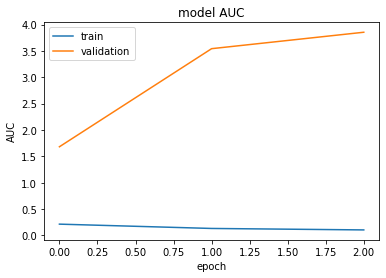

In [51]:
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.title('model AUC')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

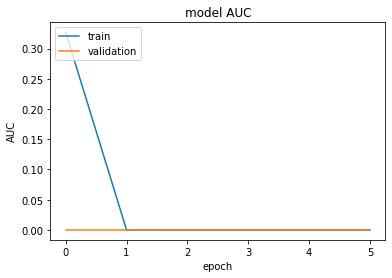

In [52]:
plt.plot(train_history_2.history['loss'])
plt.plot(train_history_2.history['auc'])
plt.title('model AUC')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()